#### Copyright 2024 Google LLC.


In [ ]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Local Agentic RAG without APIs - using FastEmbed, Ollama-Gemma 3 and Qdrant Vector database

Author: Tarun Jain

- GitHub: [lucifertrj](https://github.com/lucifertrj/)
- Twitter: [TRJ_0751](https://x.com/trj_0751)

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/google-gemini/gemma-cookbook/blob/main/Gemma/[Gemma_3]Local_Agentic_RAG.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

<br>
<br>

## Overview

We will explore how to build a 100% local agentic RAG system using open-source stack. This system allows you to create a knowledge base from web data and answer user queries without relying on external APIs, ensuring data privacy and flexibility.

Running AI inference locally — processing AI models on an organization’s own hardware, such as on-premises servers or devices, rather than relying on cloud-based services has become an increasingly popular choice across various industries. The primary appeal lies in the enhanced control and security it offers over sensitive data.  

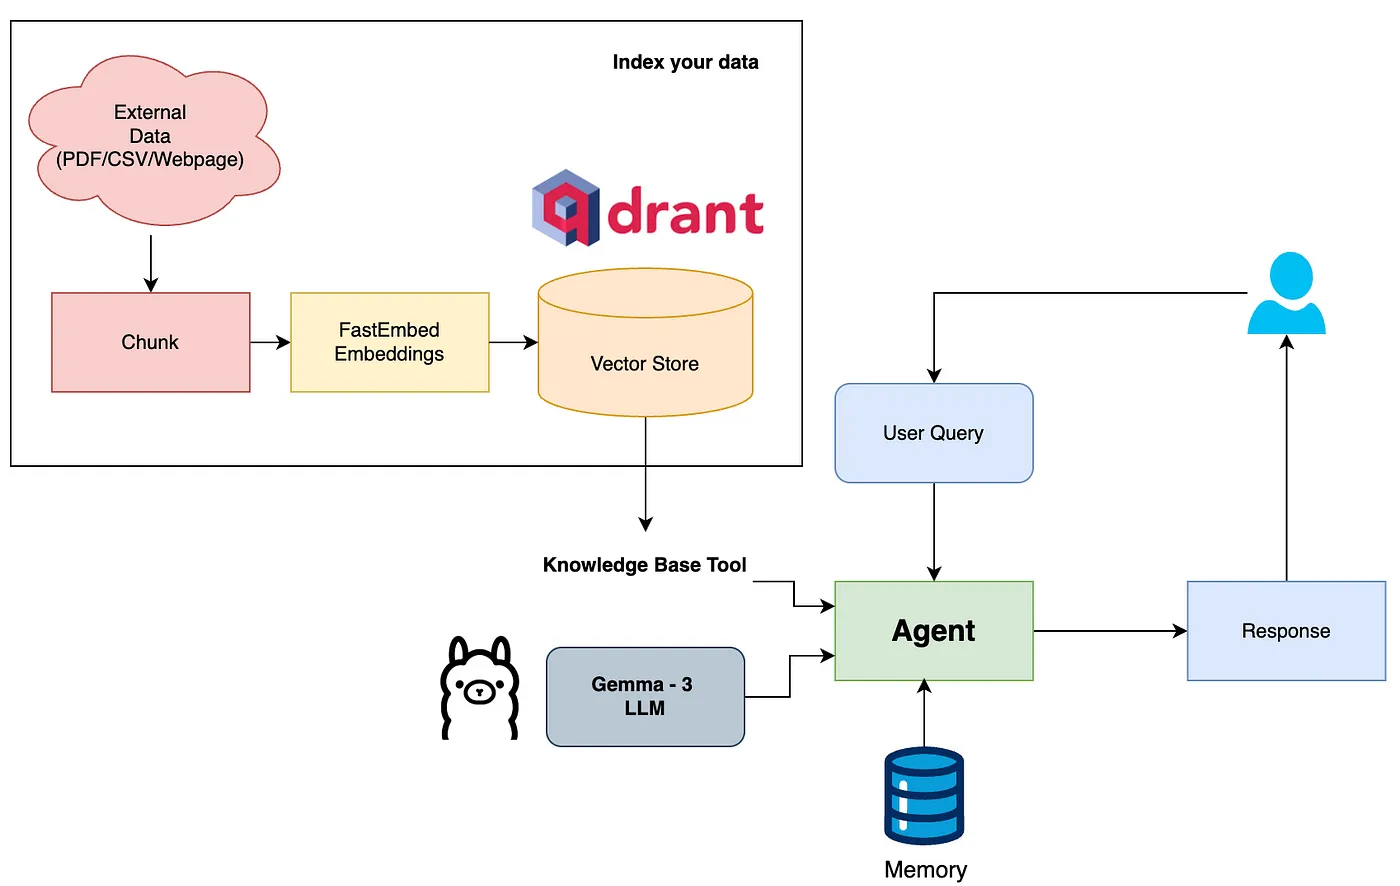

## Installation

Install Ollama through the offical installation script.

In [ ]:
!curl -fsSL https://ollama.com/install.sh | sh

>>> Cleaning up old version at /usr/local/lib/ollama
>>> Installing ollama to /usr/local
>>> Downloading Linux amd64 bundle
######################################################################## 100.0%
>>> Adding ollama user to video group...
>>> Adding current user to ollama group...
>>> Creating ollama systemd service...
>>> The Ollama API is now available at 127.0.0.1:11434.
>>> Install complete. Run "ollama" from the command line.


Install:

- Ollama: To get the open source model inference i.e., Gemma-3-4b
- Langchain: To orchestrate the Retriever pipeline by indexing the data into the knowledge base.
- FastEmbed: For the lightweight embeddings
- Qdrant: To save the vector embeddings and index the data.
- Agno: For the Agentic AI capabilites


In [ ]:
!pip install ollama
!pip install langchain langchain-community
!pip install fastembed langchain-qdrant==0.2.0
!pip install agno

## Start Ollama

Start Ollama in background using nohup.

In [ ]:
!nohup ollama serve > ollama.log &

nohup: redirecting stderr to stdout


## Switch the Runtime

- Since we are using Colab, lets switch to GPU
- Click on `Runtime` and select `Change Runtime type`
- Choose `T4 GPU` one can access it for free.

## Get Gemma 3

- Gemma 3 is available in 4 variants: 1B, 4B, 12B, and 27B.
- Pull the gemma3 model to use with the library: ollama pull gemma3:12b
- See [https://ollama.com/search](https://ollama.com/search) for more information on the models available.

In [ ]:
import ollama

In [ ]:
ollama.pull('gemma3:4b') # get the model from here: https://ollama.com/library/gemma3

ProgressResponse(status='success', completed=None, total=None, digest=None)

In [ ]:
from agno.agent import Agent
from agno.models.ollama import Ollama

In [ ]:
test_ollama = Agent(
    model=Ollama(id="gemma3:4b")
)

In [ ]:
test_ollama.print_response("who is Virat Kohli. give brief intro",stream=True)

Output()

Alright, the model is running, its time to build the Agentic RAG completely local, lets start by saving our external data into Vector database and prepare the knowledge base.

In [ ]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.embeddings.fastembed import FastEmbedEmbeddings

from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams
from qdrant_client.http.exceptions import UnexpectedResponse

## External Data

External data can be in PDF, Docx, YouTube, CSV, or any other format. For this demonstration, we’ll use a web page to demonstrate how to chat with a website.

The key objective is to load data from the URL using LangChain loaders and extract raw text. Since LLMs cannot process an entire document at once, we need to chunk the data into smaller parts. Once we have the raw text, we divide it into smaller chunks and store it in a knowledge base.

We will use Gemma-3 release blog as the external data to build the Agentic RAG.

In [ ]:
urls = [
    "https://blog.google/technology/developers/gemma-3/",
]

In [ ]:
loader = WebBaseLoader(urls)
data = loader.load()

In [ ]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1024, chunk_overlap=50
)
chunks = text_splitter.split_documents(data)

## Setup your Vector database

While defining the vector database, it’s crucial to consider that data may change over time, and preserving previous versions is important. To manage this, we define a unique collection name each time we store new data. Whenever data changes, a new collection should be used.

In [ ]:
client = QdrantClient(path="/tmp/app")
collection_name = "agent-rag"

try:
    collection_info = client.get_collection(collection_name=collection_name)
except (UnexpectedResponse, ValueError):
    client.create_collection(
        collection_name=collection_name,
        vectors_config=VectorParams(size=1024, distance=Distance.COSINE),
    )

## Index your document

Now that we’ve defined the vector database client, its time to define the embedding model. The final step to index the data is to initialize the vector store and add the chunked data for efficient retrieval.

In [ ]:
embeddings = FastEmbedEmbeddings(model_name="thenlper/gte-large")

/usr/local/lib/python3.11/dist-packages/langchain_community/embeddings/fastembed.py:109: UserWarning: The model thenlper/gte-large now uses mean pooling instead of CLS embedding. In order to preserve the previous behaviour, consider either pinning fastembed version to 0.5.1 or using `add_custom_model` functionality.
  values["model"] = fastembed.TextEmbedding(


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/660 [00:00<?, ?B/s]

model.onnx:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.41k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

In [ ]:
vector_store = QdrantVectorStore(
    client=client,
    collection_name=collection_name,
    embedding=embeddings,
)

In [ ]:
vector_store.add_documents(documents=chunks)

In [ ]:
retriever = vector_store.as_retriever()

Hurray! The data is now saved in vector database, lets cross check:

In [ ]:
!ls /tmp/app

collection  meta.json


In [ ]:
!ls /tmp/app/collection/

agent-rag


We have the agent-rag inside the collection directory, thats saved locally.

## Agentic Pipeline set

Agno offers multiple ways to define a knowledge base. In this case, we will load the LangChain retriever pipeline into Agno as a knowledge base object, enabling seamless retrieval and decision-making within the Agentic workflow.

In [ ]:
def search_and_augment(user_query):
    docs_content = retriever.invoke(user_query)

    context = ""
    for data in docs_content:
        context += data.page_content

    prompt = f"""
    Answer to the USER QUESTION from the provided CONTEXT.
    The given CONTEXT is the only source of information, if USER QUESTION is not from the given CONTEXT, just say `I don't know, no enough information`
    -----
    CONTEXT: {context}
    -----
    USER QUESTION: {user_query}
    """

    return prompt

In [ ]:
user_query = "How many global languages is supported?" # question taken from external data
user_query2 = "who is Virat Kohli?" # not from the given data

In [ ]:
agent = Agent(
    model=Ollama(id="gemma3:4b")
)

In [ ]:
prompt1 = search_and_augment(user_query)

In [ ]:
response = agent.run(prompt1)
print(response.content)

Gemma 3 offers out-of-the-box support for over 35 languages and pretrained support for over 140 languages.


Lets ask out of context question

In [ ]:
prompt2 = search_and_augment(user_query2)

In [ ]:
response = agent.run(prompt2)
print(response.content)

I don't know, no enough information


If you notice, earlier when we tested Gemma, I asked who is Virat Kohli it answered, not it didn't answer, thats what RAG is capable off. With Agentic capability it have the improved decision making ability.